Joan Carles Montero
# Machine Learning-Based Classification of Skin Lesions
## LOCAL binary classification

In [2]:
from PIL import Image
import os
import numpy as np
import pandas as pd

# Definine directory path
images_path = "data/images/"
masks_path = "data/masks/"
# Paths to the data
metadata_path = 'data/metadata.csv'
# Load the metadata
metadata = pd.read_csv(metadata_path)
print(metadata.head())

          image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0


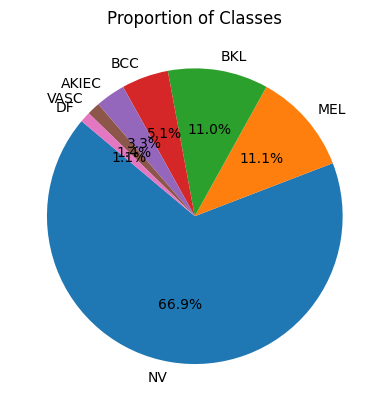

In [3]:
# Printing initial proportions
import matplotlib.pyplot as plt
# Summing up the occurrences of each class
class_counts = metadata.iloc[:, 1:].sum().sort_values(ascending=False)

# Plotting a pie chart
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of Classes')
plt.show()

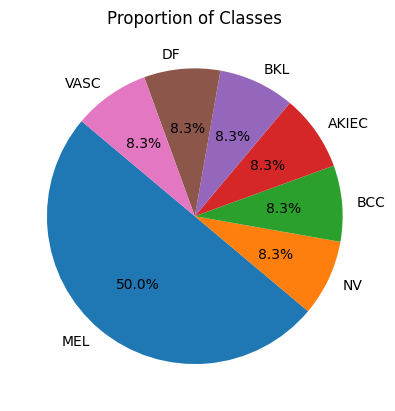

In [7]:
# Balancing the dataset to obtain 50% melanoma and 50% non-melanoma images

# Single label column that contains the class with the highest value
metadata['label'] = metadata[['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']].idxmax(axis=1)

# Number of images in total and per category
total_images = 1008
melanoma_images = total_images//2 # 504 images, 50%
non_melanoma_images = total_images - melanoma_images

# Number of non-melanoma classes
non_melanoma_classes = len(metadata['label'].unique()) - 1 # excluding MEL class

# Samples per non-melanoma class
samples_per_non_melanoma_class = non_melanoma_images // non_melanoma_classes # All other classes equally represented with 84 images 

selected_indexes = []
# Sampling for melanoma
melanoma_group = metadata[metadata['label'] == 'MEL']
selected_indexes.extend(melanoma_group.sample(n=melanoma_images, random_state=33).index.tolist())

# Sampling for non-melanoma
for label, group in metadata[metadata['label'] != 'MEL'].groupby('label'):
    if len(group) >= samples_per_non_melanoma_class:
        selected_indexes.extend(group.sample(n=samples_per_non_melanoma_class, random_state=33).index.tolist())
    else:
        selected_indexes.extend(group.sample(n=samples_per_non_melanoma_class, replace=True, random_state=33).index.tolist())

sample_metadata = metadata.loc[selected_indexes]

# Summing up the occurrences of each class
class_counts = sample_metadata.iloc[:, 1:-1].sum()

# Plotting a pie chart
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of Classes')
plt.show()

In [11]:
# Code to load images and labels as numpy objects
from tqdm import tqdm
import os
from PIL import Image
import numpy as np

# Prepare lists to hold image data and labels
image_data = []
labels = []

# Loop through the sampled metadata to load images and labels
for _, row in tqdm(sample_metadata.iterrows(), total=total_images):
    img_path = os.path.join(images_path, row['image'] + ".jpg")
    img = Image.open(img_path)
    img = img.resize((300, 225))
    img_array = np.array(img)
    
    image_data.append(img_array)
    
    # Append 1 for melanoma and 0 for non-melanoma
    label = 1 if row['label'] == 'MEL' else 0
    labels.append(label)

# Convert lists to NumPy arrays
image_data = np.array(image_data, dtype=np.uint8)
labels = np.array(labels)

print(image_data.shape)
print(labels.shape)


100%|██████████████████████████████████████████████████████████████████████████████| 1008/1008 [00:17<00:00, 58.27it/s]

(1008, 225, 300, 3)
(1008,)


In [12]:
# Save the data
np.save("images_mel.npy", image_data)
np.save("labels_mel.npy", labels)

In [13]:
# Code to upload the files to Google Drive
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
import os
import pickle

# The SCOPES are the permissions the application will ask for.
SCOPES = ['https://www.googleapis.com/auth/drive.file']

def authenticate_google_app():
    creds = None
    # The file token.pickle stores the user's access and refresh tokens, and is
    # created automatically when the authorization flow completes for the first
    # time.
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            creds = pickle.load(token)
    # If there are no (valid) credentials available, let the user log in.
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file('credentials.json', SCOPES)
            creds = flow.run_local_server(port=0)
        # Save the credentials for the next run
        with open('token.pickle', 'wb') as token:
            pickle.dump(creds, token)

    return creds

def upload_file(filename, path, folder_id=None):
    creds = authenticate_google_app()
    service = build('drive', 'v3', credentials=creds)

    file_metadata = {'name': filename}
    if folder_id:  # If a folder ID was provided, use it.
        file_metadata['parents'] = [folder_id]

    media = MediaFileUpload(path, mimetype='application/octet-stream')
    file = service.files().create(body=file_metadata,
                                  media_body=media,
                                  fields='id').execute()
    print(f'File ID: {file.get("id")}')


upload_file('images_mel.npy', 'images_mel.npy', '1csxpugE12Rn2B9GFmkW2-UrJZPbr_Wgu')
upload_file('labels_mel.npy', 'labels_mel.npy', '1csxpugE12Rn2B9GFmkW2-UrJZPbr_Wgu')

File ID: 16TcIdoiZ5LYkBnR80IpAdIYQneOQ_gAW
File ID: 1r18UjbCgLuP8AXzs86u4xQDl9118OW0c
